In [1]:
import datacube
from dc_notebook_utilities import create_platform_product_gui, generate_metadata_report, create_extents_gui 
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_mosaic import (create_mosaic, ls7_unpack_qa, create_median_mosaic,
                                                 create_max_ndvi_mosaic, create_min_ndvi_mosaic)
from utils.data_cube_utilities.dc_display_map import display_map
from ipywidgets import widgets
import collections
# from collections import Counter
import operator
import datetime
import numpy as np

'Basemap' was not found in 'mpl_toolkits.basemap'.  It is likely that 'mpl_toolkits.basemap' is not present


In [2]:
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")
from utils.data_cube_utilities.data_access_api import DataAccessApi

In [3]:
#Get all the current datacube products
products = dc.list_products()

In [4]:
###If we decide we are avoiding widgets...
platform = ["LANDSAT_7"]
product = ["ls7_ledaps_kenya"]

In [5]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product[0])

lat, lon = products.resolution[products.platform == platform[0]].any()

In [6]:
#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)
max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3) 

#display area
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [7]:
# Display metadata
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

,Min,Max,Resolution
Date:,2005-1-8,2016-12-24,
Longitude:,34.655,36.899,0.000269995
Latitude:,-0.942,0.95,-0.000271302


In [8]:
extent_values = create_extents_gui(min_date_str, max_date_str,
                                   min_lon_rounded, max_lon_rounded,
                                   min_lat_rounded, max_lat_rounded)

Label(value='Start date: ')

Text(value='2005-1-8')

Label(value='End date: ')

Text(value='2016-12-24')

Label(value='Min lon: ')

BoundedFloatText(value=34.655, max=36.899, min=34.655)

Label(value='Max lon: ')

BoundedFloatText(value=36.899, max=36.899, min=34.655)

Label(value='Min lat: ')

BoundedFloatText(value=-0.942, max=0.95, min=-0.942)

Label(value='Max lat: ')

BoundedFloatText(value=0.95, max=0.95, min=-0.942)

In [10]:
# Save form values
start_date = datetime.datetime.strptime(extent_values[0].value, '%Y-%m-%d')
end_date = datetime.datetime.strptime(extent_values[1].value, '%Y-%m-%d')
min_lon = extent_values[2].value
max_lon = extent_values[3].value
min_lat = extent_values[4].value
max_lat = extent_values[5].value

#get a list of available aquisition dates
acquisitions_list = api.list_acquisition_dates(product[0], longitude=(min_lon, max_lon), latitude=(min_lat, max_lat))
print(len(acquisitions_list))

174


In [11]:
#define query parameters
params= dict(platform=platform[0],
             product=product[0],
             lon=(min_lon, max_lon),
             lat=(min_lat, max_lat),
             measurements = ["red", "nir", "pixel_qa"])

# Query the Data Cube
dataset = dc.load(**params)

In [28]:
#Make a function for this since we will be doing this multiple times
def create_clean_mask(dataset):
    #Clean mask creation to filter out pixels that are not suitable for analysis
    clear_xarray  = ls7_unpack_qa(dataset.pixel_qa, "clear")  
    water_xarray  = ls7_unpack_qa(dataset.pixel_qa, "water")
    
    #use logical or statement to elect viable pixels for analysis
    return np.logical_or(clear_xarray.values.astype(bool), water_xarray.values.astype(bool))


clean_mask = create_clean_mask(dataset)

In [29]:
scene_sel = widgets.Dropdown(options=acquisitions_list,
                                    values=acquisitions_list)

baseline_sel = widgets.SelectMultiple(options=acquisitions_list,
                                    values=acquisitions_list)

threshold_sel_options = {str(x)+'%': x/100 for x in range(5, 101, 5)}
threshold_sel = widgets.Dropdown(options=collections.OrderedDict(sorted(threshold_sel_options.items(), key=operator.itemgetter(1))))

mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,
                   'Median':create_median_mosaic, 'Max NDVI':create_max_ndvi_mosaic, 
                   'Min NDVI':create_min_ndvi_mosaic}

mosaic_options_sel = widgets.Dropdown(options=list(mosaic_methods.keys()))
    
# Display form
display(widgets.Label('Select a scene to check for anomalies: '), scene_sel)
display(widgets.Label('Select scenes to form a baseline: '), baseline_sel)
display(widgets.Label('Select a mosaic method for the baseline:  '), mosaic_options_sel)
display(widgets.Label('Select a percentage threshold for anomalies: '), threshold_sel)

Label(value='Select a scene to check for anomalies: ')

Dropdown(options=(datetime.datetime(2005, 1, 8, 7, 38, 21), datetime.datetime(2005, 1, 24, 7, 38, 21), datetime.datetime(2005, 2, 25, 7, 38, 37), datetime.datetime(2005, 3, 13, 7, 38, 40), datetime.datetime(2005, 3, 29, 7, 38, 38), datetime.datetime(2005, 4, 14, 7, 38, 32), datetime.datetime(2005, 5, 16, 7, 38, 34), datetime.datetime(2005, 6, 1, 7, 38, 31), datetime.datetime(2005, 6, 17, 7, 38, 24), datetime.datetime(2005, 7, 3, 7, 38, 22), datetime.datetime(2005, 8, 4, 7, 38, 21), datetime.datetime(2005, 9, 5, 7, 38, 7), datetime.datetime(2005, 9, 21, 7, 38, 2), datetime.datetime(2005, 10, 7, 7, 37, 57), datetime.datetime(2006, 1, 11, 7, 38, 48), datetime.datetime(2006, 1, 27, 7, 38, 56), datetime.datetime(2006, 2, 12, 7, 39, 1), datetime.datetime(2006, 2, 28, 7, 39, 3), datetime.datetime(2006, 4, 1, 7, 39, 2), datetime.datetime(2006, 5, 3, 7, 39, 1), datetime.datetime(2006, 5, 19, 7, 39, 2), datetime.datetime(2006, 6, 4, 7, 39), datetime.datetime(2006, 10, 10, 7, 38, 21), datetime.datetime(2006, 11, 11, 7, 38, 51), datetime.datetime(2006, 12, 13, 7, 39, 7), datetime.datetime(2007, 2, 15, 7, 39, 23), datetime.datetime(2007, 3, 3, 7, 39, 27), datetime.datetime(2007, 3, 19, 7, 39, 29), datetime.datetime(2007, 4, 4, 7, 39, 29), datetime.datetime(2007, 4, 20, 7, 39, 27), datetime.datetime(2007, 5, 6, 7, 39, 23), datetime.datetime(2007, 5, 22, 7, 39, 16), datetime.datetime(2007, 6, 7, 7, 39, 13), datetime.datetime(2007, 7, 9, 7, 39, 11), datetime.datetime(2007, 8, 10, 7, 39, 2), datetime.datetime(2007, 8, 26, 7, 38, 55), datetime.datetime(2007, 9, 27, 7, 38, 43), datetime.datetime(2007, 10, 13, 7, 38, 43), datetime.datetime(2007, 10, 29, 7, 38, 55), datetime.datetime(2007, 11, 14, 7, 39, 4), datetime.datetime(2007, 11, 30, 7, 39, 11), datetime.datetime(2007, 12, 16, 7, 39, 16), datetime.datetime(2008, 1, 1, 7, 39, 18), datetime.datetime(2008, 3, 5, 7, 39, 8), datetime.datetime(2008, 4, 6, 7, 39, 6), datetime.datetime(2008, 8, 28, 7, 38, 1), datetime.datetime(2008, 9, 13, 7, 37, 53), datetime.datetime(2008, 9, 29, 7, 37, 44), datetime.datetime(2008, 10, 15, 7, 37, 38), datetime.datetime(2008, 10, 31, 7, 37, 54), datetime.datetime(2008, 11, 16, 7, 38, 8), datetime.datetime(2008, 12, 18, 7, 38, 29), datetime.datetime(2009, 1, 3, 7, 38, 35), datetime.datetime(2009, 1, 19, 7, 38, 41), datetime.datetime(2009, 2, 4, 7, 38, 45), datetime.datetime(2009, 2, 20, 7, 38, 55), datetime.datetime(2009, 3, 8, 7, 39, 4), datetime.datetime(2009, 3, 24, 7, 39, 11), datetime.datetime(2009, 4, 9, 7, 39, 16), datetime.datetime(2009, 4, 25, 7, 39, 21), datetime.datetime(2009, 6, 12, 7, 39, 23), datetime.datetime(2009, 6, 28, 7, 39, 21), datetime.datetime(2009, 7, 14, 7, 39, 17), datetime.datetime(2009, 7, 30, 7, 39, 12), datetime.datetime(2009, 8, 31, 7, 39, 8), datetime.datetime(2009, 9, 16, 7, 39, 7), datetime.datetime(2009, 10, 2, 7, 39, 4), datetime.datetime(2009, 12, 21, 7, 40, 4), datetime.datetime(2010, 1, 6, 7, 40, 20), datetime.datetime(2010, 1, 22, 7, 40, 35), datetime.datetime(2010, 4, 12, 7, 41, 10), datetime.datetime(2010, 4, 28, 7, 41, 9), datetime.datetime(2010, 5, 30, 7, 41, 5), datetime.datetime(2010, 7, 17, 7, 41, 11), datetime.datetime(2010, 8, 2, 7, 41, 10), datetime.datetime(2010, 8, 18, 7, 41, 11), datetime.datetime(2010, 9, 3, 7, 41, 14), datetime.datetime(2010, 10, 5, 7, 41, 13), datetime.datetime(2011, 2, 10, 7, 42, 23), datetime.datetime(2011, 2, 26, 7, 42, 28), datetime.datetime(2011, 3, 30, 7, 42, 34), datetime.datetime(2011, 4, 15, 7, 42, 34), datetime.datetime(2011, 8, 21, 7, 42, 21), datetime.datetime(2011, 9, 22, 7, 42, 13), datetime.datetime(2011, 10, 8, 7, 42, 10), datetime.datetime(2011, 12, 11, 7, 42, 44), datetime.datetime(2012, 1, 12, 7, 42, 59), datetime.datetime(2012, 1, 28, 7, 42, 59), datetime.datetime(2012, 2, 13, 7, 43, 5), datetime.datetime(2012, 5, 19, 7, 43, 39), datetime.datetime(2012, 6, 4, 7, 43, 18), datetime.datetime(2012, 9, 8, 7, 44, 21), datetime.datetime(2012, 9, 24, 7, 44, 30), datetime.datetime(20

Label(value='Select scenes to form a baseline: ')

SelectMultiple(options=(datetime.datetime(2005, 1, 8, 7, 38, 21), datetime.datetime(2005, 1, 24, 7, 38, 21), datetime.datetime(2005, 2, 25, 7, 38, 37), datetime.datetime(2005, 3, 13, 7, 38, 40), datetime.datetime(2005, 3, 29, 7, 38, 38), datetime.datetime(2005, 4, 14, 7, 38, 32), datetime.datetime(2005, 5, 16, 7, 38, 34), datetime.datetime(2005, 6, 1, 7, 38, 31), datetime.datetime(2005, 6, 17, 7, 38, 24), datetime.datetime(2005, 7, 3, 7, 38, 22), datetime.datetime(2005, 8, 4, 7, 38, 21), datetime.datetime(2005, 9, 5, 7, 38, 7), datetime.datetime(2005, 9, 21, 7, 38, 2), datetime.datetime(2005, 10, 7, 7, 37, 57), datetime.datetime(2006, 1, 11, 7, 38, 48), datetime.datetime(2006, 1, 27, 7, 38, 56), datetime.datetime(2006, 2, 12, 7, 39, 1), datetime.datetime(2006, 2, 28, 7, 39, 3), datetime.datetime(2006, 4, 1, 7, 39, 2), datetime.datetime(2006, 5, 3, 7, 39, 1), datetime.datetime(2006, 5, 19, 7, 39, 2), datetime.datetime(2006, 6, 4, 7, 39), datetime.datetime(2006, 10, 10, 7, 38, 21), datetime.datetime(2006, 11, 11, 7, 38, 51), datetime.datetime(2006, 12, 13, 7, 39, 7), datetime.datetime(2007, 2, 15, 7, 39, 23), datetime.datetime(2007, 3, 3, 7, 39, 27), datetime.datetime(2007, 3, 19, 7, 39, 29), datetime.datetime(2007, 4, 4, 7, 39, 29), datetime.datetime(2007, 4, 20, 7, 39, 27), datetime.datetime(2007, 5, 6, 7, 39, 23), datetime.datetime(2007, 5, 22, 7, 39, 16), datetime.datetime(2007, 6, 7, 7, 39, 13), datetime.datetime(2007, 7, 9, 7, 39, 11), datetime.datetime(2007, 8, 10, 7, 39, 2), datetime.datetime(2007, 8, 26, 7, 38, 55), datetime.datetime(2007, 9, 27, 7, 38, 43), datetime.datetime(2007, 10, 13, 7, 38, 43), datetime.datetime(2007, 10, 29, 7, 38, 55), datetime.datetime(2007, 11, 14, 7, 39, 4), datetime.datetime(2007, 11, 30, 7, 39, 11), datetime.datetime(2007, 12, 16, 7, 39, 16), datetime.datetime(2008, 1, 1, 7, 39, 18), datetime.datetime(2008, 3, 5, 7, 39, 8), datetime.datetime(2008, 4, 6, 7, 39, 6), datetime.datetime(2008, 8, 28, 7, 38, 1), datetime.datetime(2008, 9, 13, 7, 37, 53), datetime.datetime(2008, 9, 29, 7, 37, 44), datetime.datetime(2008, 10, 15, 7, 37, 38), datetime.datetime(2008, 10, 31, 7, 37, 54), datetime.datetime(2008, 11, 16, 7, 38, 8), datetime.datetime(2008, 12, 18, 7, 38, 29), datetime.datetime(2009, 1, 3, 7, 38, 35), datetime.datetime(2009, 1, 19, 7, 38, 41), datetime.datetime(2009, 2, 4, 7, 38, 45), datetime.datetime(2009, 2, 20, 7, 38, 55), datetime.datetime(2009, 3, 8, 7, 39, 4), datetime.datetime(2009, 3, 24, 7, 39, 11), datetime.datetime(2009, 4, 9, 7, 39, 16), datetime.datetime(2009, 4, 25, 7, 39, 21), datetime.datetime(2009, 6, 12, 7, 39, 23), datetime.datetime(2009, 6, 28, 7, 39, 21), datetime.datetime(2009, 7, 14, 7, 39, 17), datetime.datetime(2009, 7, 30, 7, 39, 12), datetime.datetime(2009, 8, 31, 7, 39, 8), datetime.datetime(2009, 9, 16, 7, 39, 7), datetime.datetime(2009, 10, 2, 7, 39, 4), datetime.datetime(2009, 12, 21, 7, 40, 4), datetime.datetime(2010, 1, 6, 7, 40, 20), datetime.datetime(2010, 1, 22, 7, 40, 35), datetime.datetime(2010, 4, 12, 7, 41, 10), datetime.datetime(2010, 4, 28, 7, 41, 9), datetime.datetime(2010, 5, 30, 7, 41, 5), datetime.datetime(2010, 7, 17, 7, 41, 11), datetime.datetime(2010, 8, 2, 7, 41, 10), datetime.datetime(2010, 8, 18, 7, 41, 11), datetime.datetime(2010, 9, 3, 7, 41, 14), datetime.datetime(2010, 10, 5, 7, 41, 13), datetime.datetime(2011, 2, 10, 7, 42, 23), datetime.datetime(2011, 2, 26, 7, 42, 28), datetime.datetime(2011, 3, 30, 7, 42, 34), datetime.datetime(2011, 4, 15, 7, 42, 34), datetime.datetime(2011, 8, 21, 7, 42, 21), datetime.datetime(2011, 9, 22, 7, 42, 13), datetime.datetime(2011, 10, 8, 7, 42, 10), datetime.datetime(2011, 12, 11, 7, 42, 44), datetime.datetime(2012, 1, 12, 7, 42, 59), datetime.datetime(2012, 1, 28, 7, 42, 59), datetime.datetime(2012, 2, 13, 7, 43, 5), datetime.datetime(2012, 5, 19, 7, 43, 39), datetime.datetime(2012, 6, 4, 7, 43, 18), datetime.datetime(2012, 9, 8, 7, 44, 21), datetime.datetime(2012, 9, 24, 7, 44, 30), datetime.datet

Label(value='Select a mosaic method for the baseline:  ')

Dropdown(options=('Most Recent', 'Min NDVI', 'Max NDVI', 'Median', 'Least Recent'), value='Most Recent')

Label(value='Select a percentage threshold for anomalies: ')

Dropdown(options=OrderedDict([('5%', 0.05), ('10%', 0.1), ('15%', 0.15), ('20%', 0.2), ('25%', 0.25), ('30%', 0.3), ('35%', 0.35), ('40%', 0.4), ('45%', 0.45), ('50%', 0.5), ('55%', 0.55), ('60%', 0.6), ('65%', 0.65), ('70%', 0.7), ('75%', 0.75), ('80%', 0.8), ('85%', 0.85), ('90%', 0.9), ('95%', 0.95), ('100%', 1.0)]), value=0.05)

In [31]:
#Apply clean mask to dataset
cleaned_dataset = create_mosaic(dataset, reverse_time=False, clean_mask=clean_mask)

#Initialize baseline mosaic for comparison
baseline_mosaic = None

#need to reverse the direction of the mosaicing over time if "Most Recent" selected
reverse_time = True if mosaic_options_sel.value.title() == 'Most Recent' else False
for index in range(len(baseline_sel.value)):
    data = api.get_dataset_by_extent(product[0], latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), 
                                    time=(baseline_sel.value[index],(baseline_sel.value[index+1] if index != len(baseline_sel.value)-1 else baseline_sel.value[index]+datetime.timedelta(seconds=1))),
                                    measurements=['red', 'nir', 'pixel_qa'])
    clean_mask = create_clean_mask(data)
    baseline_mosaic = mosaic_methods[mosaic_options_sel.value](data, intermediate_product=baseline_mosaic, reverse_time=reverse_time, clean_mask=clean_mask)

In [32]:
ndvi_baseline = (baseline_mosaic.nir - baseline_mosaic.red) / (baseline_mosaic.nir + baseline_mosaic.red)
ndvi_scene = (cleaned_dataset.nir - cleaned_dataset.red) / (cleaned_dataset.nir + cleaned_dataset.red)
percentage_change = abs((ndvi_baseline - ndvi_scene) / ndvi_baseline)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive


<xarray.DataArray (latitude: 743, longitude: 743)>
array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0.,  0.,  0.],
       [inf, inf, inf, ...,  0.,  0.,  0.],
       [inf, inf, inf, ...,  0.,  0.,  0.]])
Coordinates:
  * latitude   (latitude) float64 0.2001 0.1998 0.1996 0.1993 0.199 0.1988 ...
  * longitude  (longitude) float64 35.0 35.0 35.0 35.0 35.0 35.0 35.0 35.0 ...


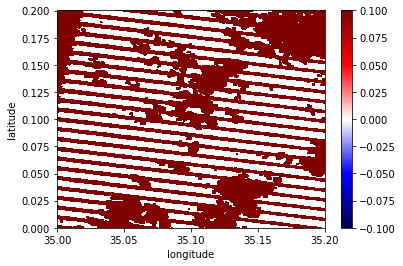

In [33]:
anomalies = percentage_change
print(percentage_change)
anomalies.plot(cmap='seismic')